In [1]:
from math import e, factorial,log, gamma, sqrt, floor
from matplotlib import pyplot as pt
from numpy.random import geometric,exponential,poisson
from scipy.stats import ks_2samp
from scipy.stats import norm
from numpy import linspace
from IPython.display import Markdown
from analysis import *
from threading import Thread

In [2]:
pt.rcParams["figure.figsize"] = (20,10)

# Load data

This is a comment


In [3]:
Ttx = 30
Trx = 60
Tn = 100
    
def compute_histogram(r1,r2):

    Eb1,Es1,En1 = computeEvents(r1,Ttx,Trx,Tn)
    Eb2,Es2,En2 = computeEvents(r2,Ttx,Trx,Tn)
    display(Markdown('<span style="color: #af0000">'+"P(S) = %.6f"%(Trx*Es1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #00af00">'+"P(N) = %.6f"%(Tn*En1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #0000af">'+"P(B) = %.6f"%(Ttx*Eb1/len(r1))+'</span>'))

    Pb2 = Eb2*Ttx/(Eb2*Ttx+En2*Tn+Es2*Trx)
    rt1 = Pb2/(Ttx/1000)
    
    print("r(B)(Events/s) = %.6f"%(rt1))
    
    hist1 = genWindowHistogram(r1,r2,1000)
    Esuc = checkSuccess(r2,r1)
    Ps=Esuc/Eb2
    rs2 = Esuc*1000/len(r1)
    print("r(Suuccess)(Events/s) = %.6f"%rs2)
    Pscan = Trx*Es1/len(r1)
    r_scan = 1000*Pscan/Trx
    print("r(S)(Events/s) = %.6f"%r_scan)
    Ns = Ps*1000/Ttx
    Nb = rt1*1000
    print("Success probability evts: %.6f"%(Ps))
    return hist1,Eb1,Es1,En1,Ps

<span style="color: #af0000">P(S) = 0.200706</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.799294</span>

r(B)(Events/s) = 26.678609
0.9999999999999998
r(Suuccess)(Events/s) = 5.345463
r(S)(Events/s) = 3.345098
Success probability evts: 0.200484
0.9677632170809968
---------------------


<span style="color: #af0000">P(S) = 0.299813</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.700187</span>

r(B)(Events/s) = 23.312946
1.0
r(Suuccess)(Events/s) = 6.996894
r(S)(Events/s) = 4.996879
Success probability evts: 0.299988
0.9939928026975716
---------------------


<span style="color: #af0000">P(S) = 0.399332</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.600668</span>

r(B)(Events/s) = 19.995691
1.0
r(Suuccess)(Events/s) = 7.987496
r(S)(Events/s) = 6.655526
Success probability evts: 0.399262
0.9981859410430839
---------------------


<span style="color: #af0000">P(S) = 0.500542</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.499458</span>

r(B)(Events/s) = 16.674931
0.9999999999999999
r(Suuccess)(Events/s) = 8.338113
r(S)(Events/s) = 8.342361
Success probability evts: 0.500302
0.9989254029738848
---------------------


<span style="color: #af0000">P(S) = 0.600737</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.399263</span>

r(B)(Events/s) = 13.324660
1.0000000000000002
r(Suuccess)(Events/s) = 8.008611
r(S)(Events/s) = 10.012286
Success probability evts: 0.601242
0.9990205223880597
---------------------


<span style="color: #af0000">P(S) = 0.700031</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.299969</span>

r(B)(Events/s) = 9.989371
1.0000000000000002
r(Suuccess)(Events/s) = 6.990389
r(S)(Events/s) = 11.667180
Success probability evts: 0.699628
0.9987650308742282
---------------------


<span style="color: #af0000">P(S) = 0.799829</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.200171</span>

r(B)(Events/s) = 6.686156
1.0000000000000002
r(Suuccess)(Events/s) = 5.349603
r(S)(Events/s) = 13.330481
Success probability evts: 0.800377
0.9945792410937532
---------------------


<span style="color: #af0000">P(S) = 0.900191</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.099809</span>

r(B)(Events/s) = 3.341943
1.0
r(Suuccess)(Events/s) = 3.007189
r(S)(Events/s) = 15.003188
Success probability evts: 0.900200
0.9484556869214554
---------------------


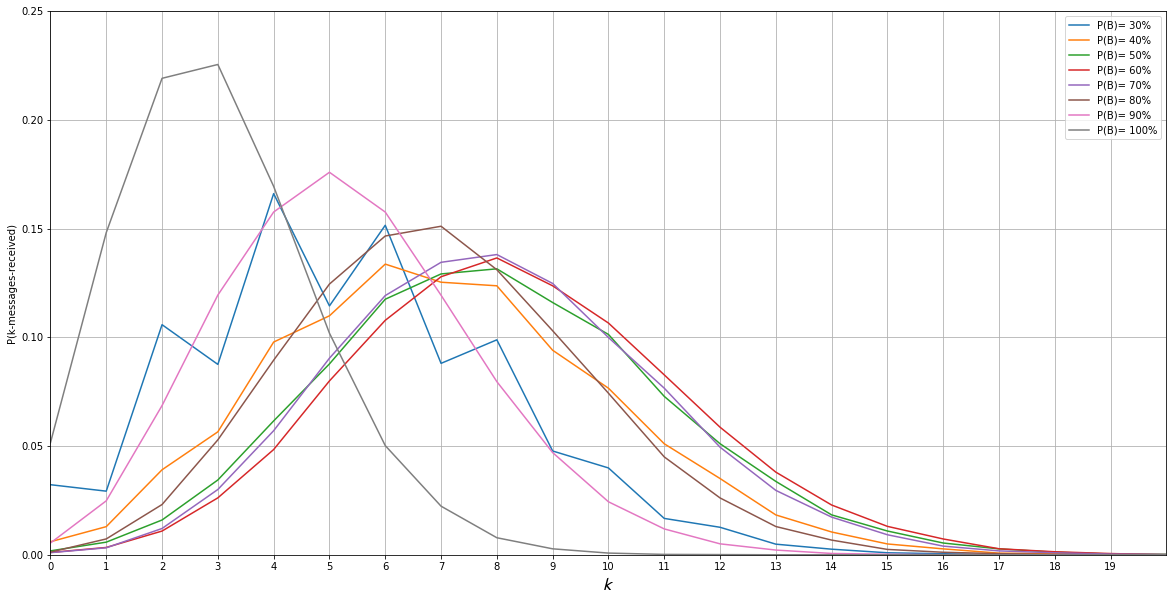

In [10]:
leg = [20,30,40,50,60,70,80,90]
for i in range(1,9):
    f1 = open("r%d-d0-result.txt"%i)
    raw1 = f1.read()
    f1.close()

    f2 = open("r%d-d1-result.txt"%i)
    raw2 = f2.read()
    f2.close()

    hist,Eb,Es,En,Ps = compute_histogram(raw1,raw2)
    print(1-hist[0])
    print('---------------------')
    pt.plot(range(len(hist)),hist,label="P(B)= %d%%"%(20+i*10))
    del(hist)
    
pt.axis([0,20,0,0.25])
pt.xticks(range(20), [str(n) for n in range(20)])
pt.xlabel(r'$\mathcal{k}$', fontsize = 18)
pt.ylabel(r'P(k-messages-received)')
pt.legend()
pt.grid(True)
pt.savefig('arrival_distribution.pdf',format='pdf',dpi=300, bbox_inches='tight')
pt.show()